# Gravitational Model Plotting

In this tutorial, we'll overlay the amplitude of a gravitational field over the globe.

## Setup

Let's import the necessary libraries:

In [2]:
import numpy as np

import plotly.graph_objs as go

from ostk.physics.units import Length
from ostk.physics.units import Angle
from ostk.physics.time import Scale
from ostk.physics.time import Instant
from ostk.physics.time import DateTime
from ostk.physics.coordinate.spherical import LLA
from ostk.physics import Environment
from ostk.physics.environment.gravitational import Earth as EarthGravitationalModel

## Computation

In [3]:
environment = Environment.default()
earth = environment.access_celestial_object_with_name("Earth")

The considered gravitational model:

In [4]:
gravitational_model = EarthGravitationalModel(EarthGravitationalModel.Type.EGM96)

The reference gravitational model:

In [5]:
gravitational_model_ref = EarthGravitationalModel(EarthGravitationalModel.Type.WGS84)

Generate a latitude-longitude grid:

In [6]:
density = 1.0

longitudes = np.linspace(-180.0, +180.0, int(360 * density + 1))
latitudes = np.linspace(-90.0, +90.0, int(180 * density + 1))

Compute gravitational anomaly (the absolute difference between the two models):

In [7]:
instant = Instant.date_time(DateTime(2015, 1, 1, 0, 0, 0), Scale.UTC)

In [8]:
def ecef_ll(latitude_deg, longitude_deg):
    return LLA(
        Angle.degrees(latitude_deg), Angle.degrees(longitude_deg), Length.meters(0.0)
    ).to_cartesian(earth.get_equatorial_radius(), earth.get_flattening())

In [9]:
gravitational_field_magnitudes = []

for latitude in latitudes:
    tmp_gravitational_field_magnitudes = []

    for longitude in longitudes:
        gravitational_field = gravitational_model.get_field_value_at(
            ecef_ll(latitude, longitude), instant
        ).T[0]
        gravitational_field_ref = gravitational_model_ref.get_field_value_at(
            ecef_ll(latitude, longitude), instant
        ).T[0]

        gravitational_field_norm = np.linalg.norm(
            gravitational_field - gravitational_field_ref
        )

        tmp_gravitational_field_magnitudes.append(gravitational_field_norm)

    gravitational_field_magnitudes.append(tmp_gravitational_field_magnitudes)

## Display

Plot onto a sphere:

In [10]:
def map_to_sphere(lon, lat, radius=1):
    """
    Maps points of coords (lon, lat) to points onto a sphere
    """

    deg2rad = lambda deg: deg * np.pi / 180.0

    lon = np.array(lon, dtype=np.float64)
    lat = np.array(lat, dtype=np.float64)

    lon = deg2rad(lon)
    lat = deg2rad(lat)

    xs = radius * np.cos(lon) * np.cos(lat)
    ys = radius * np.sin(lon) * np.cos(lat)
    zs = radius * np.sin(lat)

    return (xs, ys, zs)

In [11]:
(XS, YS, ZS) = map_to_sphere(*np.meshgrid(longitudes, latitudes))

In [12]:
colorscale = [
    [0.0, "#313695"],
    [0.07692307692307693, "#3a67af"],
    [0.15384615384615385, "#5994c5"],
    [0.23076923076923078, "#84bbd8"],
    [0.3076923076923077, "#afdbea"],
    [0.38461538461538464, "#d8eff5"],
    [0.46153846153846156, "#d6ffe1"],
    [0.5384615384615384, "#fef4ac"],
    [0.6153846153846154, "#fed987"],
    [0.6923076923076923, "#fdb264"],
    [0.7692307692307693, "#f78249"],
    [0.8461538461538461, "#e75435"],
    [0.9230769230769231, "#cc2727"],
    [1.0, "#a50026"],
]

noaxis = dict(
    showbackground=False,
    showgrid=False,
    showline=False,
    showticklabels=False,
    ticks="",
    title="",
    zeroline=False,
)

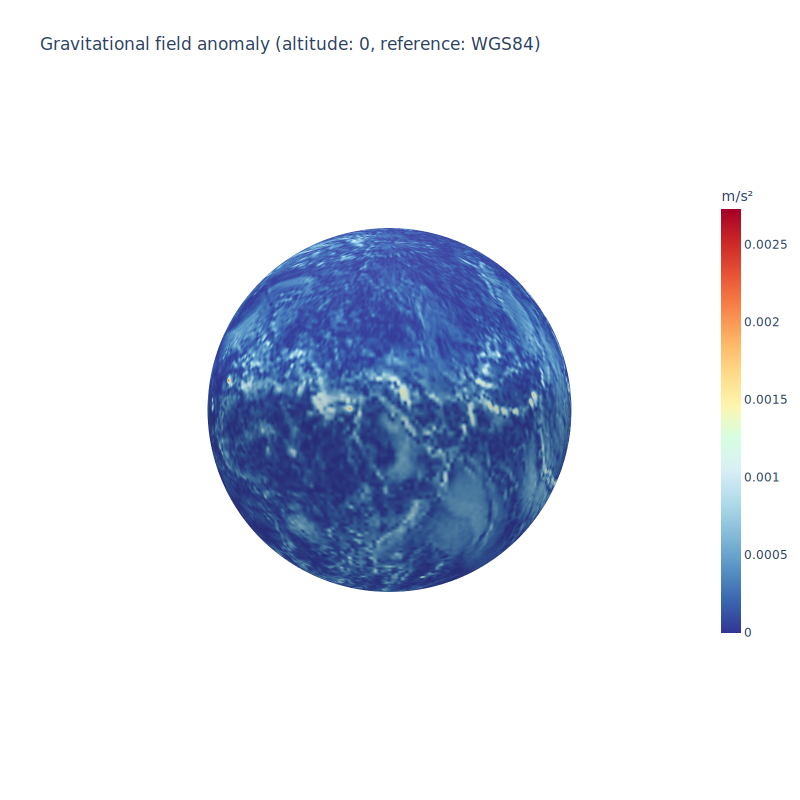

In [14]:
figure = go.Figure(
    data=[
        go.Surface(
            x=XS,
            y=YS,
            z=ZS,
            surfacecolor=gravitational_field_magnitudes,
            colorscale=colorscale,
            cmin=np.min(gravitational_field_magnitudes),
            cmax=np.max(gravitational_field_magnitudes),
            colorbar=go.surface.ColorBar(
                title="m/s²", thickness=20, len=0.75, ticklen=4
            ),
        )
    ],
    layout=go.Layout(
        title="Gravitational field anomaly (altitude: 0, reference: WGS84)",
        width=800,
        height=800,
        scene=go.layout.Scene(
            xaxis=noaxis,
            yaxis=noaxis,
            zaxis=noaxis,
            aspectratio=go.layout.scene.Aspectratio(x=1, y=1, z=1),
            camera=dict(eye=dict(x=1.15, y=1.15, z=1.15)),
        ),
    ),
)

figure.show("svg")

## References

- https://plot.ly/~empet/14813/heatmap-plot-on-a-spherical-map/#/
- https://cddis.nasa.gov/926/egm96/egm96.html
- https://people.sc.fsu.edu/~lb13f/projects/space_environment/egm96.php
- https://plotlyblog.tumblr.com/post/171585173862/how-to-create-2d-and-3d-interactive-weather-maps

---